# Markov chain Monte Carlo

In [1]:
import numpy as np
import numpy.random as npr
import scipy.stats as spr
from itertools import combinations
import matplotlib.pyplot as plt

## Metropolis–Hastings algorithm

Generate a given probability distribution using the Metropolis-Hastings algorithm.

In [2]:
def calc_chain_mg(n, gap, s):
    chain = np.empty(gap + n, dtype=np.uint16)
    chain[0] = 1
    for i in range(gap + n - 1):
        if chain[i] == 1:
            if npr.rand() < 0.5 ** (s + 1):
                chain[i + 1] = 2
            else:
                chain[i + 1] = 1
        else:
            if npr.rand() < 0.5:
                chain[i + 1] = chain[i] - 1
            else:
                if npr.rand() < (chain[i] / (chain[i] + 1)) ** s:
                    chain[i + 1] = chain[i] + 1
                else:
                    chain[i + 1] = chain[i]
    return chain[gap:]

def calc_p_calc_mg(chain):
    return (np.bincount(chain) / len(chain))[1:]

def calc_p_orig_mg(n, s):
    p_orig = np.arange(1, n + 1)
    p_orig = p_orig ** -s
    p_orig /= 2.61238
    return p_orig

def plot_prob_comp_mg(chain, s, ax):
    p_calc = calc_p_calc_mg(chain)
    p_orig = calc_p_orig_mg(len(p_calc), s)
    ax.plot(p_calc, label='Empirical')
    ax.plot(p_orig, label='Theoretical')
    ax.set_title('States distribution')
    ax.legend()

def plot_error_by_length_mg(chain, step, s, ax):
    x = np.arange(0, len(chain), step)
    y = np.empty_like(x, dtype=np.float64)
    p_orig = calc_p_orig_mg(np.max(chain), s)
    for i in range(len(x)):
        sub_chain = chain[:x[i]]
        p_calc = calc_p_calc_mg(sub_chain)
        p_calc = np.concatenate((p_calc, np.zeros(len(p_orig) - len(p_calc))))
        y[i] = np.mean(np.abs((p_calc - p_orig)))
    ax.plot(x, y)
    ax.set_title('Error by chain length')

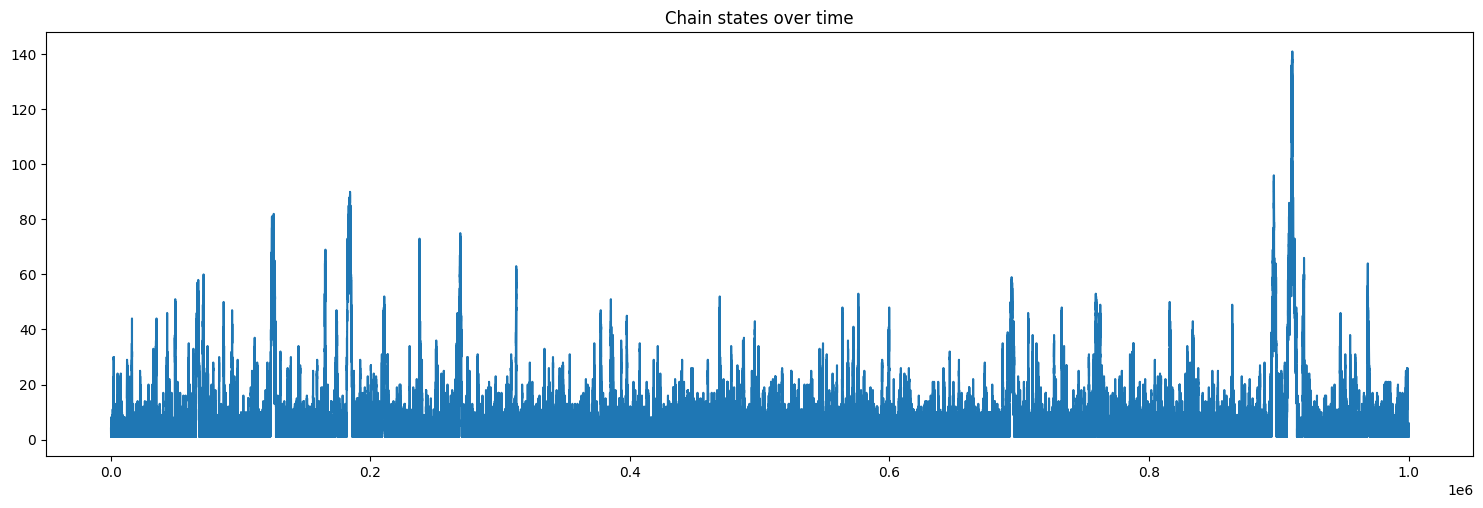

In [3]:
chain_mg = calc_chain_mg(1000000, 10000, 1.5)
plt.figure(figsize=(15, 5))
plt.title('Chain states over time')
plt.tight_layout()
plt.plot(chain_mg)

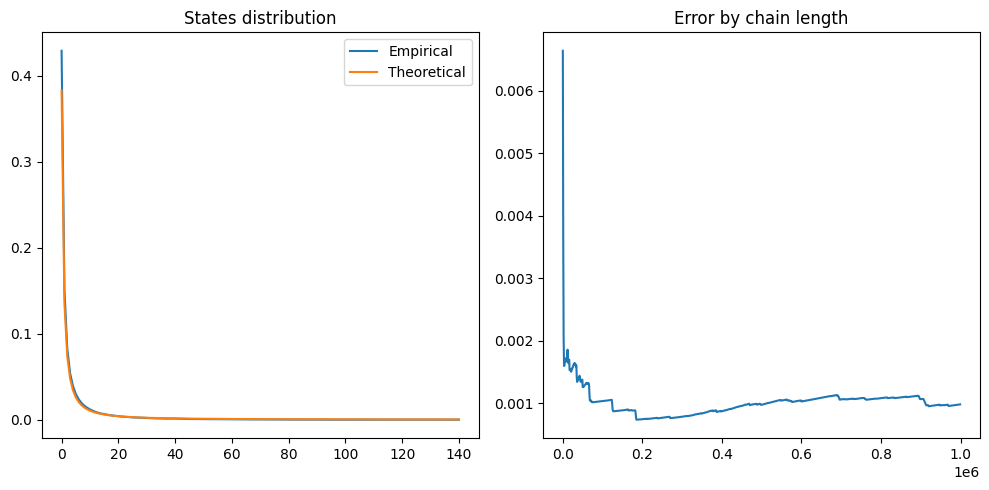

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_prob_comp_mg(chain_mg, 1.5, ax1)
plot_error_by_length_mg(chain_mg, 1000, 1.5, ax2)
plt.tight_layout()
plt.show()

## Ising model

In [11]:
def evolve_iz(lattice, b, steps):
    n, m = lattice.shape
    curr = lattice.copy()
    for i in range(steps):
        y = npr.randint(0, n)
        x = npr.randint(0, m)
        d = 0
        if y > 0:
            d += 1 if curr[y - 1, x] else -1
        if y < n - 1:
            d += 1 if curr[y + 1, x] else -1
        if x > 0:
            d += 1 if curr[y, x - 1] else -1
        if x < m - 1:
            d += 1 if curr[y, x + 1] else -1
        d *= 2
        if not curr[y, x]:
            d = -d
        if npr.rand() < np.exp(-b * d):
            curr[y, x] = not curr[y, x]
    return curr

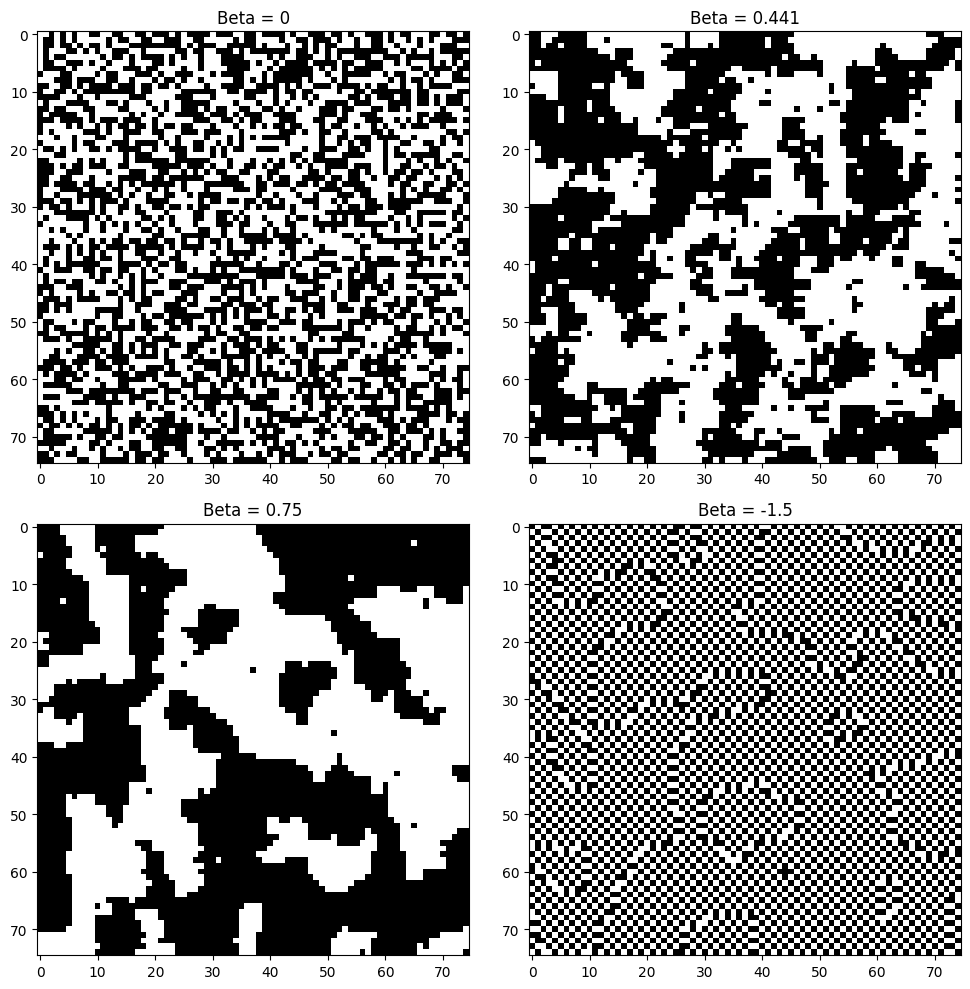

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1), plt.imshow(evolve_iz(npr.choice([True, False], size=(75, 75)), 0, 100000), cmap='gray'), plt.title('Beta = 0')
plt.subplot(2, 2, 2), plt.imshow(evolve_iz(npr.choice([True, False], size=(75, 75)), 0.441, 100000), cmap='gray'), plt.title('Beta = 0.441')
plt.subplot(2, 2, 3), plt.imshow(evolve_iz(npr.choice([True, False], size=(75, 75)), 0.75, 100000), cmap='gray'), plt.title('Beta = 0.75')
plt.subplot(2, 2, 4), plt.imshow(evolve_iz(npr.choice([True, False], size=(75, 75)), -1.5, 100000), cmap='gray'), plt.title('Beta = -1.5')
plt.tight_layout()
plt.show()

## Beta distribution

In [13]:
def calc_chain_beta(n, gap, a, b):
    chain = np.empty(gap + n, dtype=np.float64)
    chain[0] = npr.rand()
    for i in range(gap + n - 1):
        u = npr.rand()
        if npr.rand() < (u ** (a - 1) * (1 - u) ** (b - 1)) / (chain[i] ** (a - 1) * (1 - chain[i]) ** (b - 1)):
            chain[i + 1] = u
        else:
            chain[i + 1] = chain[i]
    return chain[gap:]

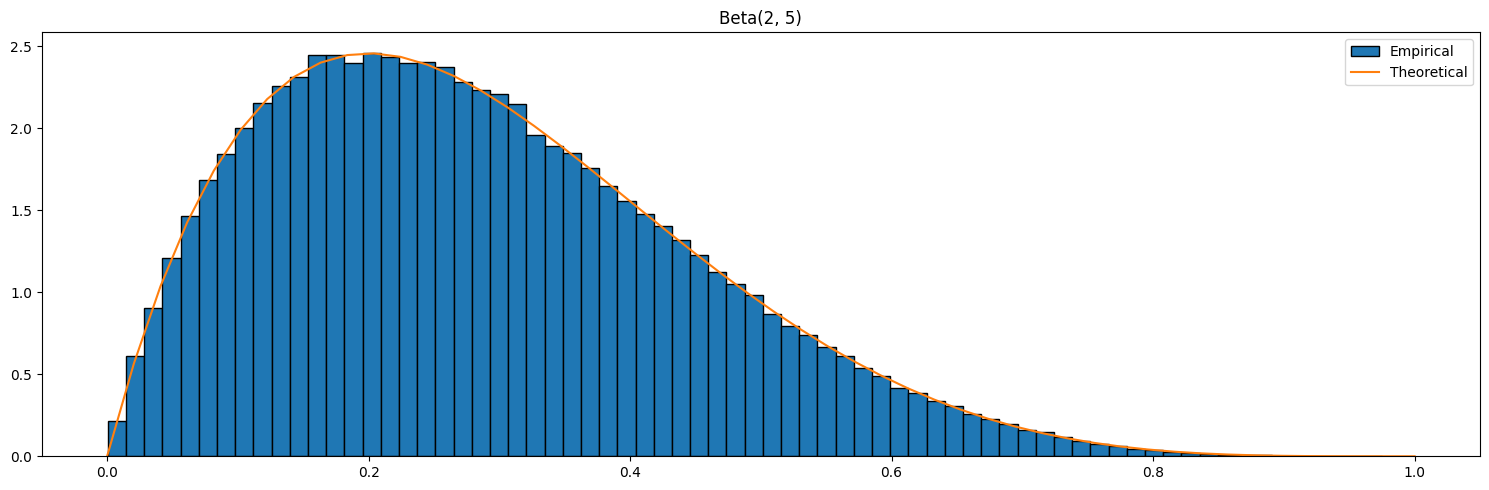

In [14]:
chain_beta = calc_chain_beta(1000000, 1000, 2, 5)
plt.figure(figsize=(15, 5))
plt.hist(chain_beta, 70, density=True, edgecolor='black', label='Empirical')
space_beta = np.linspace(0, 1)
plt.plot(space_beta, spr.beta.pdf(space_beta, 2, 5), label='Theoretical')
plt.title('Beta(2, 5)')
plt.legend()
plt.tight_layout()
plt.show()

## 2-Dimensional normal distribution

In [15]:
def calc_chain_normal(n, gap, ro):
    x = np.empty(gap + n, dtype=np.float32)
    y = np.empty(gap + n, dtype=np.float32)
    x[0] = 0
    y[0] = 0
    for i in range(gap + n - 1):
        x[i + 1] = npr.normal(ro * y[i], 1 - ro ** 2)
        y[i + 1] = npr.normal(ro * x[i + 1], 1 - ro ** 2)
    return x[gap:], y[gap:]

def plot_normal(x, y):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1), plt.scatter(x, y, alpha=0.3)
    hist, xedges, yedges = np.histogram2d(x, y, bins=21)
    X, Y = np.meshgrid(xedges, yedges)
    plt.subplot(1, 2, 2), plt.pcolormesh(X, Y, hist.T)
    plt.tight_layout()
    plt.show()

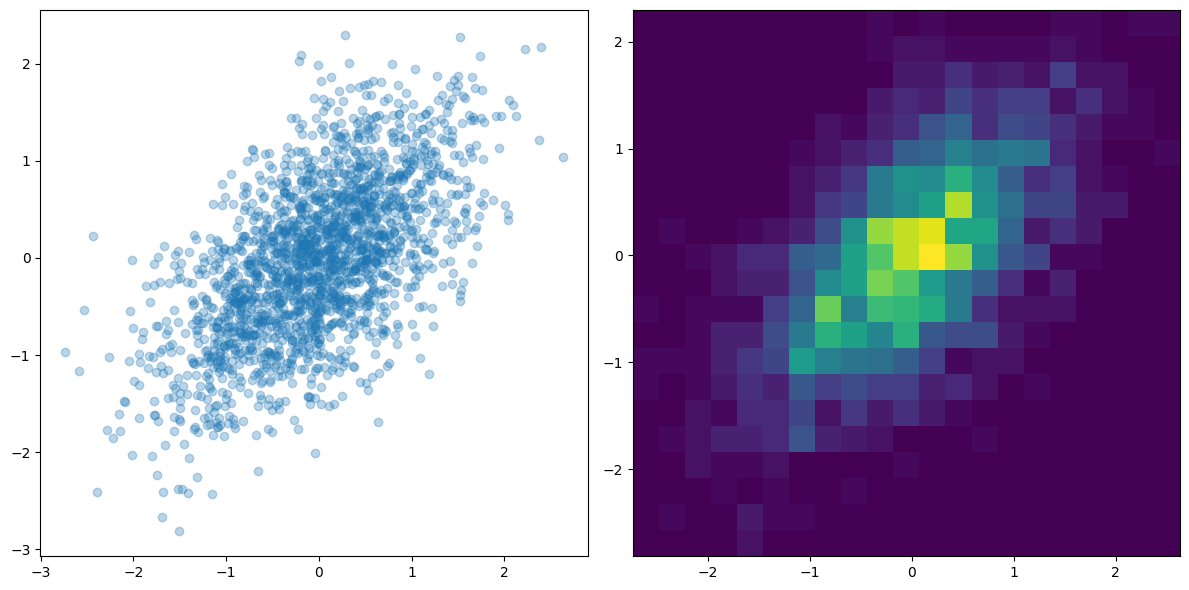

In [16]:
x_normal, y_normal = calc_chain_normal(2000, 20, 0.6)
plot_normal(x_normal,y_normal)

## Posterior normal distribution

In [17]:
def calc_chain_ap(n, gap, y, mu, s2, t2, d):
    x = np.empty(gap + n)
    x[0] = npr.normal(mu, t2)
    for i in range(gap + n - 1):
        nxt = npr.normal(x[i], d ** 2)
        if npr.rand() < np.exp(-1/(2 * s2) * ((y - nxt) ** 2 - (y - x[i]) ** 2) - 1/(2 * t2) * ((nxt - mu) ** 2 - (x[i] - mu) ** 2)):
            x[i + 1] = nxt
        else:
            x[i + 1] = x[i]
    return x[gap:]

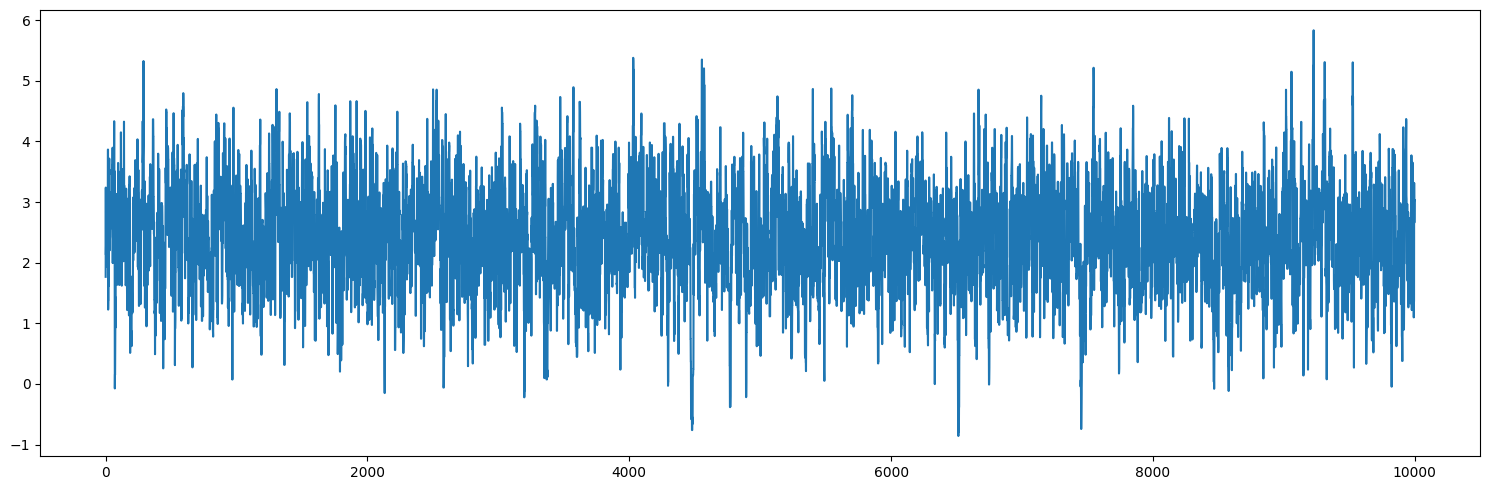

In [18]:
chain_ap = calc_chain_ap(10000, 100, y=3, mu=0, s2=1, t2=4, d=1)
plt.figure(figsize=(15, 5))
plt.plot(chain_ap)
plt.tight_layout()
plt.show()

In [19]:
print('Empirical:')
print(f'M = {np.mean(chain_ap)}; D = {np.var(chain_ap)}')
print('Theoretical:')
print(f'M = 2.4; D = 0.8')

Empirical:
M = 2.43078681317972; D = 0.8324383949035158
Theoretical:
M = 2.4; D = 0.8


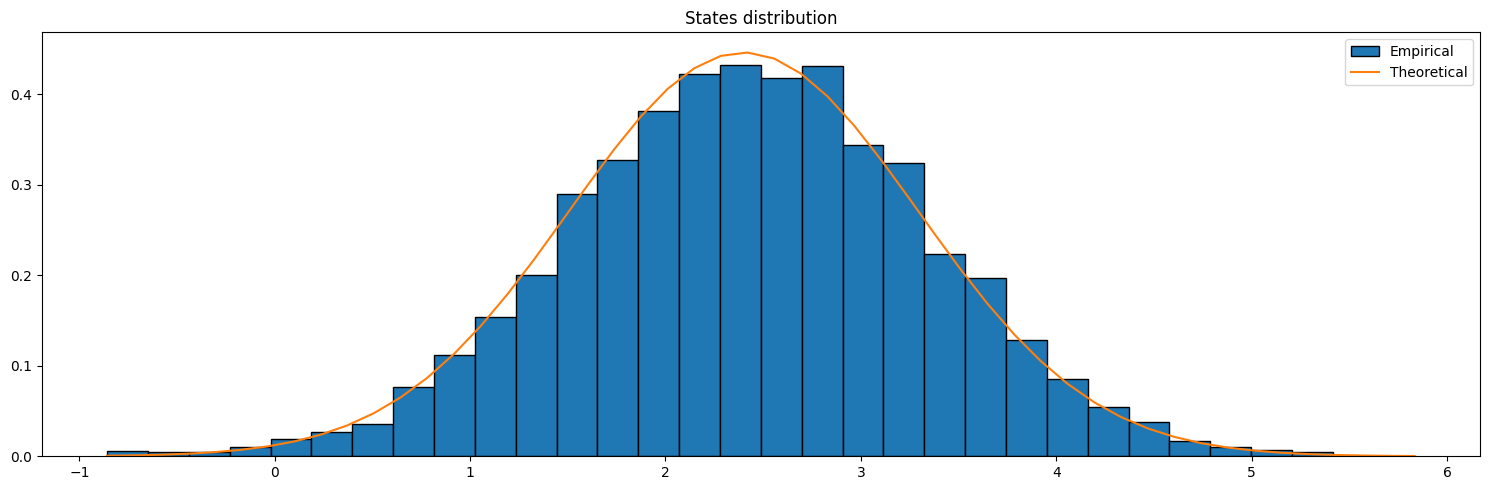

In [20]:
plt.figure(figsize=(15, 5))
plt.hist(chain_ap, bins=32, density=True, edgecolor='black', label='Empirical')
space_ap = np.linspace(np.min(chain_ap), np.max(chain_ap))
plt.plot(space_ap, spr.norm.pdf(space_ap, 2.4, np.sqrt(0.8)), label='Theoretical')
plt.title('States distribution')
plt.legend()
plt.tight_layout()
plt.show()

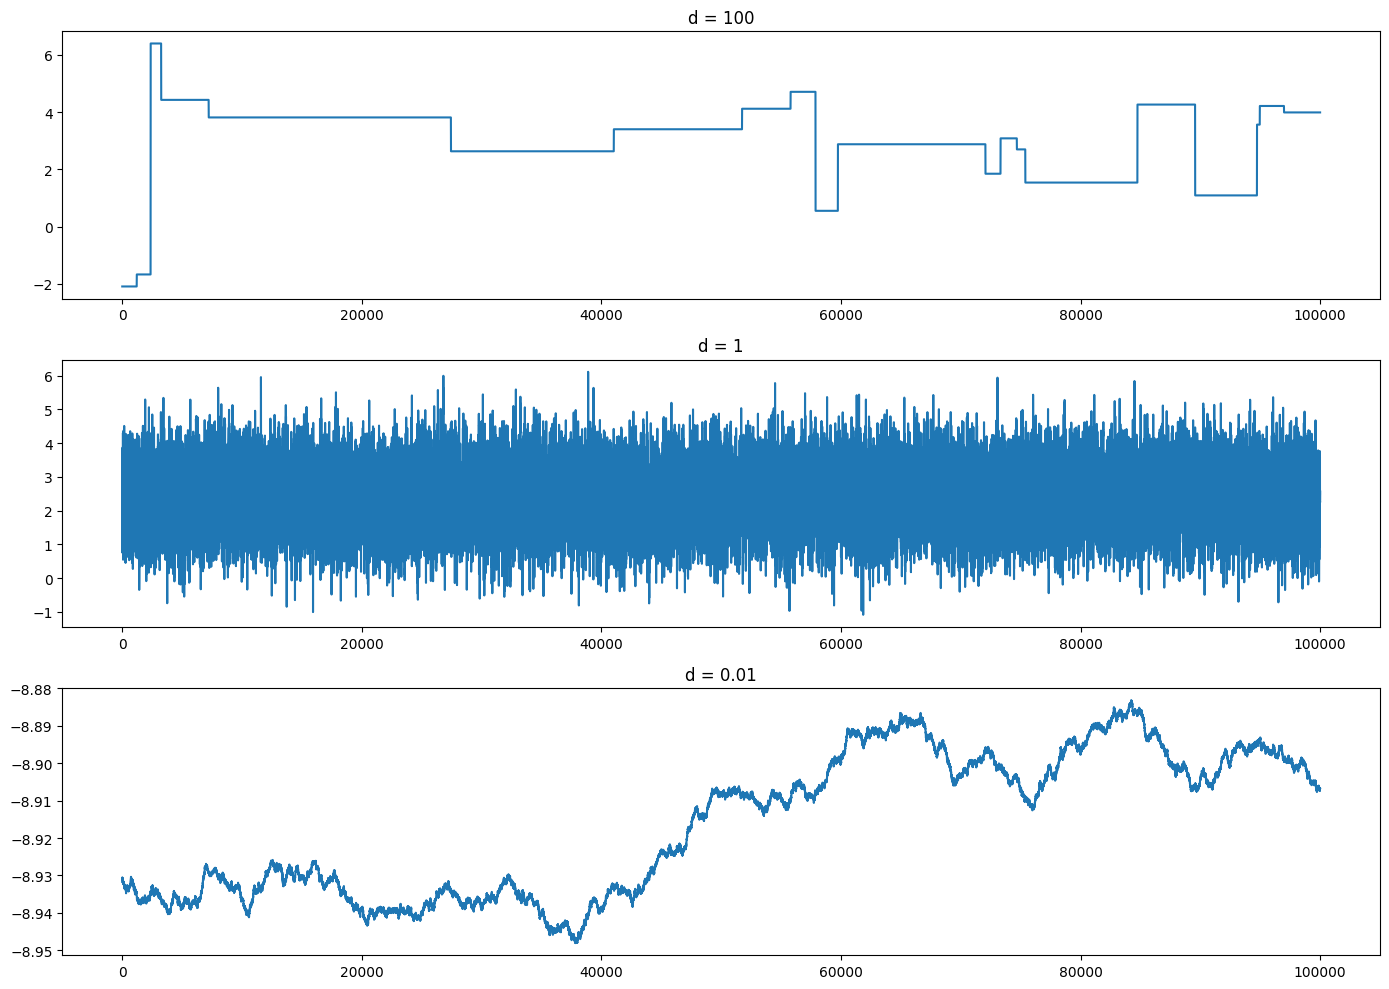

In [21]:
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1), plt.plot(calc_chain_ap(100000, 100, y=3, mu=0, s2=1, t2=4, d=100)), plt.title('d = 100')
plt.subplot(3, 1, 2), plt.plot(calc_chain_ap(100000, 100, y=3, mu=0, s2=1, t2=4, d=1)), plt.title('d = 1')
plt.subplot(3, 1, 3), plt.plot(calc_chain_ap(100000, 100, y=3, mu=0, s2=1, t2=4, d=0.01)), plt.title('d = 0.01')
plt.tight_layout()
plt.show()

## 3-Dimensional distribution (Binomial, Beta, Poisson)

In [22]:
def calc_xpn_3d(steps, gap, x_start, p_start, n_start):
    x = np.empty(gap + steps, dtype=np.int32)
    p = np.empty(gap + steps, dtype=np.float64)
    n = np.empty(gap + steps, dtype=np.int32)
    x[0], p[0], n[0] = x_start, p_start, n_start
    for i in range(gap + steps - 1):
        x[i + 1] = spr.binom.rvs(n[i], p[i])
        p[i + 1] = spr.beta.rvs(x[i + 1] + 1, n[i] - x[i + 1] + 1)
        n[i + 1] = x[i + 1] + npr.poisson(4 * (1 - p[i + 1]))
    return x[gap:], p[gap:], n[gap:]

def calc_xp_3d(steps, gap, x_start, p_start, n_const):
    x = np.empty(gap + steps, dtype=np.int32)
    p = np.empty(gap + steps, dtype=np.float64)
    x[0], p[0], n = x_start, p_start, n_const
    for i in range(gap + steps - 1):
        x[i + 1] = spr.binom.rvs(n, p[i])
        p[i + 1] = spr.beta.rvs(x[i + 1] + 1, n - x[i + 1] + 1)
    return x[gap:], p[gap:]

def calc_xn_3d(steps, gap, x_start, p_const, n_start):
    x = np.empty(gap + steps, dtype=np.int32)
    n = np.empty(gap + steps, dtype=np.int32)
    x[0], p, n[0] = x_start, p_const, n_start
    for i in range(gap + steps - 1):
        x[i + 1] = spr.binom.rvs(n[i], p)
        n[i + 1] = x[i + 1] + npr.poisson(4 * (1 - p))
    return x[gap:], n[gap:]

def calc_pn_3d(steps, gap, x_const, p_start, n_start):
    p = np.empty(gap + steps, dtype=np.float64)
    n = np.empty(gap + steps, dtype=np.int32)
    x, p[0], n[0] = x_const, p_start, n_start
    for i in range(gap + steps - 1):
        p[i + 1] = spr.beta.rvs(x + 1, n[i] - x + 1)
        n[i + 1] = x + npr.poisson(4 * (1 - p[i + 1]))
    return p[gap:], n[gap:]

def calc_x_3d(steps, gap, x_start, p_const, n_const):
    x = np.empty(gap + steps, dtype=np.int32)
    x[0], p, n = x_start, p_const, n_const
    for i in range(gap + steps - 1):
        x[i + 1] = spr.binom.rvs(n, p)
    return x[gap:]

def calc_p_3d(steps, gap, x_const, p_start, n_const):
    p = np.empty(gap + steps, dtype=np.float64)
    x, p[0], n = x_const, p_start, n_const
    for i in range(gap + steps - 1):
        p[i + 1] = spr.beta.rvs(x + 1, n - x + 1)
    return p[gap:]

def calc_n_3d(steps, gap, x_const, p_const, n_start):
    n = np.empty(gap + steps, dtype=np.int32)
    x, p, n[0] = x_const, p_const, n_start
    for i in range(gap + steps - 1):
        n[i + 1] = x + npr.poisson(4 * (1 - p))
    return n[gap:]

In [23]:
def plot_xpn_3d(chain):
    x, p, n = chain
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, p, n, alpha=0.05)
    plt.title('(X, P, N)')
    plt.tight_layout()
    plt.show()

def plot_xp_3d(chain, ax):
    x, p = chain
    xedges = np.linspace(np.min(x) - 0.5, np.max(x) + 0.5, np.max(x) - np.min(x) + 2)
    hist, xedges, yedges = np.histogram2d(x, p, bins=(xedges, 16))
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist.T)
    ax.set_title('(X, P)')

def plot_xn_3d(chain, ax):
    x, n = chain
    xedges = np.linspace(np.min(x) - 0.5, np.max(x) + 0.5, np.max(x) - np.min(x) + 2)
    yedges = np.linspace(np.min(n) - 0.5, np.max(n) + 0.5, np.max(n) - np.min(n) + 2)
    hist, xedges, yedges = np.histogram2d(x, n, bins=(xedges, yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist.T)
    ax.set_title('(X, N)')

def plot_pn_3d(chain, ax):
    p, n = chain
    yedges = np.linspace(np.min(n) - 0.5, np.max(n) + 0.5, np.max(n) - np.min(n) + 2)
    hist, xedges, yedges = np.histogram2d(p, n, bins=(16, yedges))
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist.T)
    ax.set_title('(P, N)')

def plot_xp_xn_pn_3d(chain_xp, chain_xn, chain_pn):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plot_xp_3d(chain_xp, ax1)
    plot_xn_3d(chain_xn, ax2)
    plot_pn_3d(chain_pn, ax3)
    plt.tight_layout()
    plt.show()

def plot_x_3d(x, p, n):
    bin_calculated = np.bincount(x) / len(x)
    bars = np.arange(len(bin_calculated))
    bin_original = spr.binom.pmf(bars, n, p)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.bar(bars, bin_calculated), plt.title('Empirical')
    plt.subplot(1, 3, 2), plt.bar(bars, bin_original), plt.title('Theoretical')
    plt.subplot(1, 3, 3), plt.bar(bars, bin_calculated - bin_original), plt.title('Difference')
    plt.suptitle('(X)', fontsize=24)
    plt.tight_layout()
    plt.show()

def plot_p_3d(x, p, n):
    space = np.linspace(np.min(p), np.max(p))
    plt.figure(figsize=(15, 5))
    plt.hist(p, bins=50, density=True, edgecolor='black', label='Empirical')
    plt.plot(space, spr.beta.pdf(space, x + 1, n - x + 1), label='Theoretical')
    plt.suptitle('(P)', fontsize=24)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_n_3d(x, p, n):
    poiss_calculated = np.bincount(n) / len(n)
    bars = np.arange(0, np.max(n) + 1)
    poiss_original = spr.poisson.pmf(bars - x, 4 * (1 - p))
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.bar(bars, poiss_calculated), plt.title('Empirical')
    plt.subplot(1, 3, 2), plt.bar(bars, poiss_original), plt.title('Theoretical')
    plt.subplot(1, 3, 3), plt.bar(bars, poiss_calculated - poiss_original), plt.title('Difference')
    plt.suptitle('(N)', fontsize=24)
    plt.tight_layout()
    plt.show()

In [24]:
def draw_plots_3d():
    steps = 10000
    gap = 100
    x_start, p_start, n_start = 1, 0.5, 2
    x_const, p_const, n_const = 1, 0.5, 4
    
    plot_xpn_3d(calc_xpn_3d(steps, gap, x_start, p_start, n_start))
    plot_xp_xn_pn_3d(
        calc_xp_3d(steps, gap, x_start, p_start, n_const),
        calc_xn_3d(steps, gap, x_start, p_const, n_start),
        calc_pn_3d(steps, gap, x_const, p_start, n_start)
    )
    plot_x_3d(calc_x_3d(steps, gap, x_start, p_const, n_const), p_const, n_const)
    plot_p_3d(x_const, calc_p_3d(steps, gap, x_const, p_start, n_const), n_const)
    plot_n_3d(x_const, p_const, calc_n_3d(steps, gap, x_const, p_const, n_start))

Для двовимірних та одновимірних розподілів значення марківського ланцюгу було обраховано окремо, взявши за відсутні параметри деякі константи (1, 0.5, 4 для x, p, n відповідно).

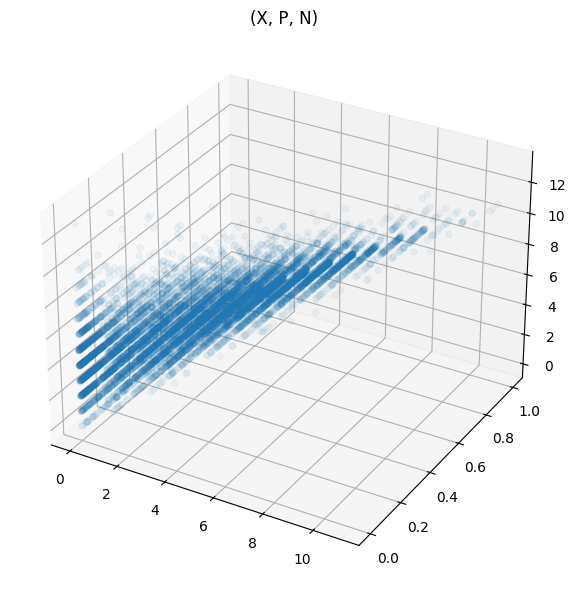

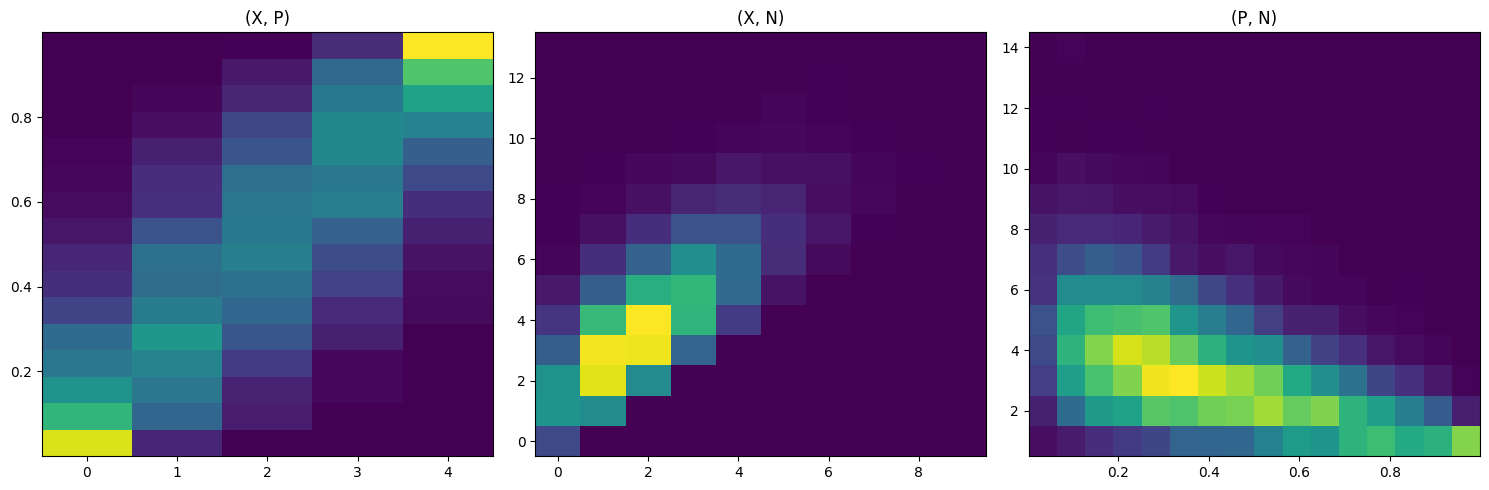

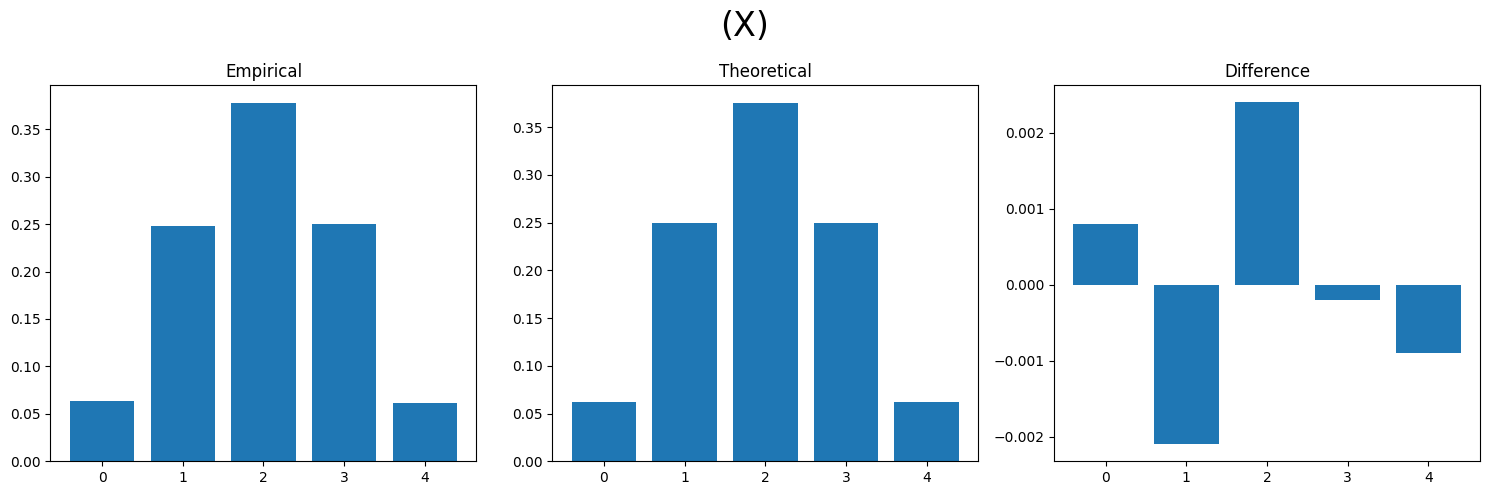

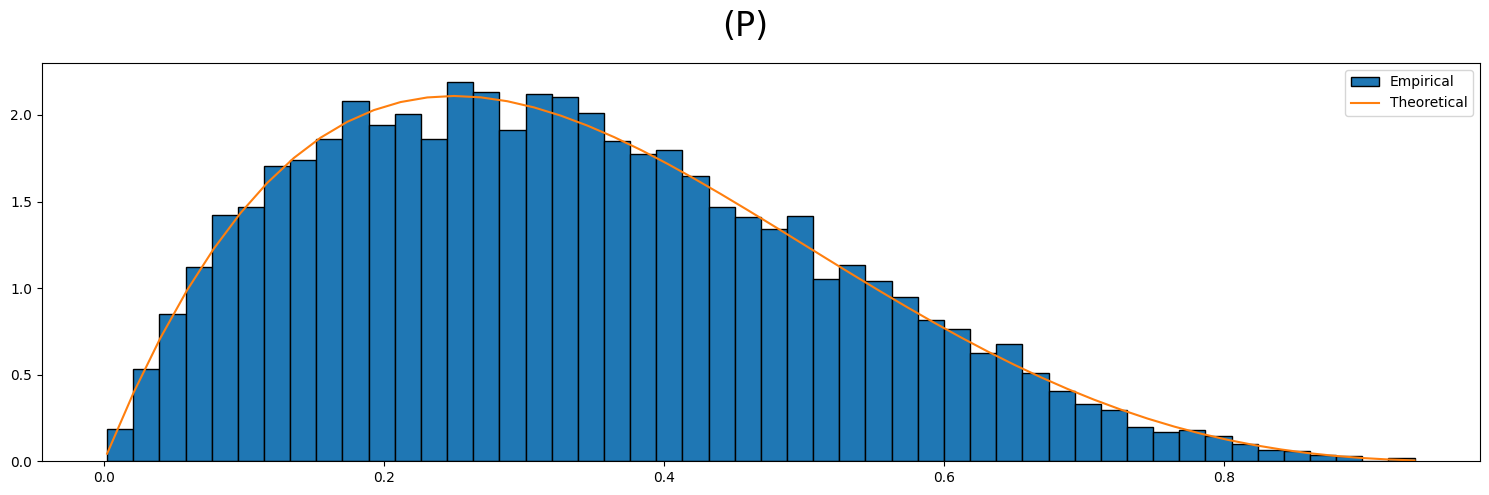

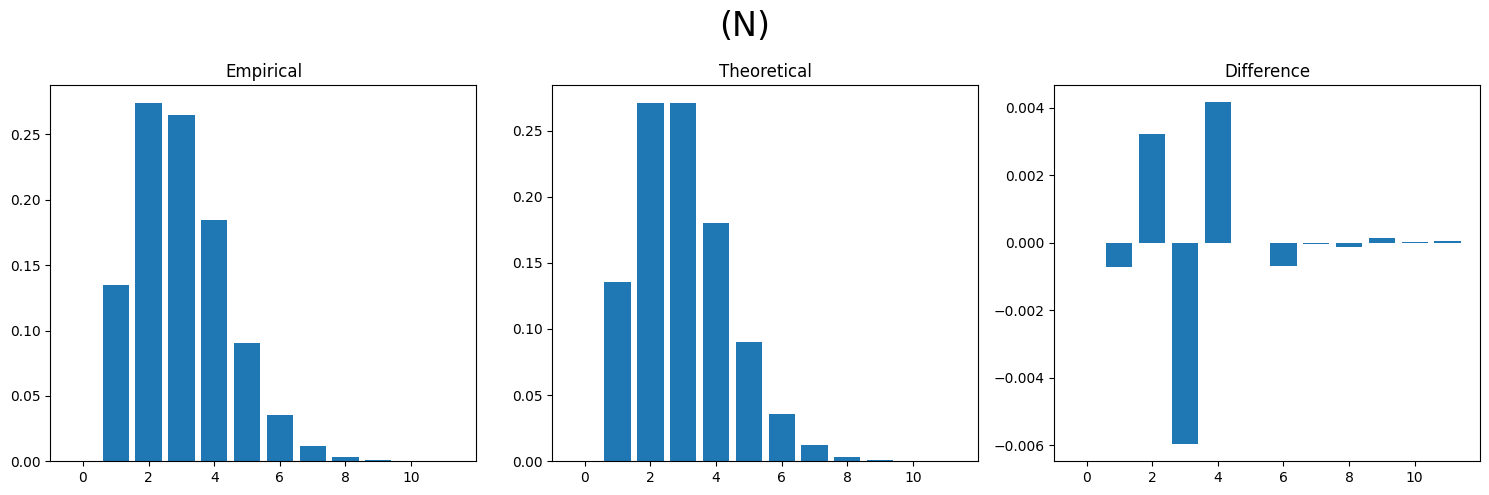

In [25]:
draw_plots_3d()

## Markov chain on the set of binary tables

Initiate a Markov chain on the set of binary tables with fixed row and column sums, for which the invariant distribution is the uniform distribution on the set of such tables.

In [36]:
def pack_is(arr):
    return np.packbits(arr).view(np.uint16)[0]

def unpack_is(packed):
    return np.unpackbits(np.array([packed]).view(np.uint8))[:12].reshape(3, 4)

def is_chess_is(matrix, h1, h2, v1, v2):
    chess_candidate = np.array([
        [matrix[v1, h1], matrix[v1, h2]],
        [matrix[v2, h1], matrix[v2, h2]]
    ])
    return np.array_equal(chess_candidate, np.array([[1, 0], [0, 1]])) or np.array_equal(chess_candidate, np.array([[0, 1], [1, 0]]))

def count_chess_is(matrix):
    count = 0
    for h1, h2 in combinations(np.arange(4), 2):
        for v1, v2 in combinations(np.arange(3), 2):
            if is_chess_is(matrix, h1, h2, v1, v2):
                count += 1
    return count

def calc_chain_is(steps, gap, start):
    chain = np.empty(gap + steps, dtype=np.uint16)
    curr = unpack_is(start)
    nxt = np.empty_like(curr)
    chain[0] = pack_is(curr)
    for i in range(gap + steps - 1):
        h1, h2 = npr.choice(4, size=2, replace=False)
        v1, v2 = npr.choice(3, size=2, replace=False)
        while not is_chess_is(curr, h1, h2, v1, v2):
            h1, h2 = npr.choice(4, size=2, replace=False)
            v1, v2 = npr.choice(3, size=2, replace=False)
        nxt[...] = curr[...]
        nxt[v1, h1] = not nxt[v1, h1]
        nxt[v1, h2] = not nxt[v1, h2]
        nxt[v2, h1] = not nxt[v1, h1]
        nxt[v2, h2] = not nxt[v1, h2]
        if npr.rand() < count_chess_is(curr) / count_chess_is(nxt):
            chain[i + 1] = pack_is(nxt)
            curr[...] = nxt[...]
        else:
            chain[i + 1] = chain[i]
    return chain[gap:]

def plot_is(chain):
    un, cnt = np.unique(chain, return_counts=True)
    plt.bar(un.astype(str), cnt / len(chain))
    plt.title('States distribution')

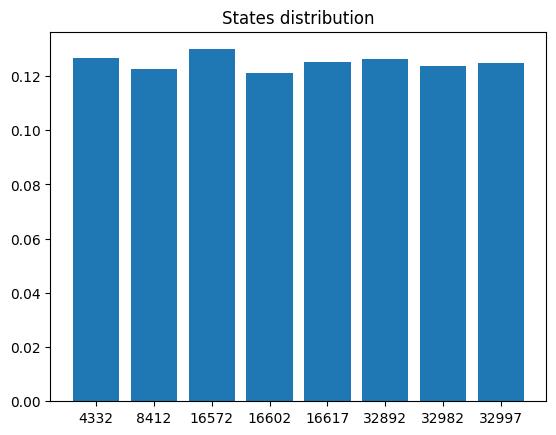

In [27]:
chain_is = calc_chain_is(10000, 100, pack_is(np.array([
    [1, 1, 1, 0],
    [1, 1, 0, 0],
    [0, 0, 0, 1]
])))
plot_is(chain_is)

In [38]:
for i in np.unique(chain_is):
    print(i, ':', sep='')
    print(unpack_is(i))

4332:
[[1 1 1 0]
 [1 1 0 0]
 [0 0 0 1]]
8412:
[[1 1 0 1]
 [1 1 0 0]
 [0 0 1 0]]
16572:
[[1 0 1 1]
 [1 1 0 0]
 [0 1 0 0]]
16602:
[[1 1 0 1]
 [1 0 1 0]
 [0 1 0 0]]
16617:
[[1 1 1 0]
 [1 0 0 1]
 [0 1 0 0]]
32892:
[[0 1 1 1]
 [1 1 0 0]
 [1 0 0 0]]
32982:
[[1 1 0 1]
 [0 1 1 0]
 [1 0 0 0]]
32997:
[[1 1 1 0]
 [0 1 0 1]
 [1 0 0 0]]
